# Pipeline de collecte des données

Le stage a pour objet le projet [Gallica Images](https://gallica.bnf.fr/accueil/fr/content/accueil-fr?mode=desktop) (2023-2026), qui vise à agréger et à indexer (à
l’aide de briques IA) les contenus iconographiques de Gallica sous la forme d’une base de
données publique dotée d’un moteur de recherche. Une des sources d’inspiration de ce
projet est le démonstrateur [GallicaPix](https://gallica.bnf.fr/blog/21062021/gallicapix-un-nouvel-outil-dexploration-iconographique?mode=desktop).

Le stage s’inscrira dans la phase de sélection du partenaire industriel chargé des
développements informatiques et dans celle de la préparation du lancement du projet (été
2023). Il aura pour objet la conception et le développement d’un banc de test du pipeline de
traitement d’images qui sera produit par le partenaire industriel lors de l’année 1 du projet,
consacrée à la réalisation d’un MVP (minimum viable product) portant sur la collectionImages de Gallica.
Ce banc de test servira à l’évaluation des performances du pipeline ainsi
qu’à sa recette finale.

Ce notebook à pour objectif la démonstration des différentes étapes du pipeline de l'entrepôt [Open Archives Initiative - Protocol for Metadata Harvesting](https://www.openarchives.org/) pour la collecte des métadonnées à la récupération des différentes images présent dans Gallica Images.

````{warning}
:class: dropdown
Ce jupyter est automatiquement charger avec les modules et packages compris. Pour lancer notebook à l'intérieur d'un [Google Colab](https://colab.research.google.com/github/gustaveturrell/gallicapix/blob/master/notebooks/pipeline/pipeline.ipynb) ou localement, vous devez 
préalablement télécharger les différents modules et installer les packages requis.    


Une fois **modules.zip** télécharger et dézipper **requirements.txt** indique les librairies disponible sur le gestionnaire de paquet **pip**
et **modules.zip** contient les différents modules **.py**. Le dossier et à placer au même niveau que le **.ipynb**



:Fichiers de téléchargement: [modules](modules/modules.zip)
````

## Les entrepôts de la BnF

La BnF gère deux types d'entrepôts où sont stockés l'ensemble des métadonnées relatives à ses documents.

Le premier ensemble de données correspond aux notices des documents numériques dont la consultation est ouverte à tout public. Un sous-ensemble important de ces notices est consultable via Gallica en particulier. Cet entrepôt contient l’ensemble des notices des documents numériques consultables dans Gallica et pour lesquels la BnF possède les fichiers numériques. La granularité de cet entrepôt est le document numérique « unitaire », tel que consulté dans Gallica : un document numérique consultable identifié par un identifiant ark unique, un enregistrement (« record »).

On appellera cet entrepôt [OAI-NUM](https://api.bnf.fr/fr/node/170). Son interrogation permet d’obtenir les métadonnées d’un document numérique dont l’identifiant ark a par exemple été trouvé dans Gallica. Il est également possible d’obtenir une liste d’identifiants de documents appartenant à un ensemble prédéfini dans l’entrepôt (appelé « set » dans la terminologie OAI).

```{code-block} xml
:name: setsxml
:caption: Extrait XML de la requête [ListSets](http://oai.bnf.fr/oai2//OAIHandler?verb=ListSets) qui liste l'ensemble des sets présent dans l'entrepôt

<set>
<setSpec>gallica:typedoc:periodiques</setSpec>
<setName>Gallica : types de documents : périodiques imprimés</setName>
<setDescription>
<oai_dc:dc xmlns:oai_dc="http://www.openarchives.org/OAI/2.0/oai_dc/" xmlns:dc="http://purl.org/dc/elements/1.1/" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/oai_dc/ http://www.openarchives.org/OAI/2.0/oai_dc.xsd">
<dc:description xml:lang="fre">Cet ensemble donne accès aux journaux, revues et autres publications périodiques imprimées de Gallica.</dc:description>
<dc:description xml:lang="eng">This set provides access to the printed press, journals and serials in Gallica.</dc:description>
</oai_dc:dc>
</setDescription>
</set>
```


```{note} Arborescence des collections
:class: dropdown
L'arborescence des sets et analogue aux dossiers et sous dossiers, dans l'exemple ci dessus gallica est le le dossier racine et et périodiques le dossier enfant de typedoc qui lui même le dossier enfant de gallica.   
Cela permet de récupérer des ensembles de records disposant de parent commun.
```


### La collecte de métadonnées à travers `oai.py`

In [6]:
#!pip install -r modules/requirements.txt

In [1]:
from modules.oai import OAINUM
from fnmatch import fnmatch
from pprint import pprint
import os

Créer une instance `gallica` et récupère l'ensemble des sets présent à l'intérieur de l'entrepôt

In [2]:
gallica = OAINUM('http://oai.bnf.fr/oai2//OAIHandler')
setspec,setname = gallica.listSets
len(setspec),setspec[250], setname[250]

(544, 'gallica:corpus:BNUStr059', 'Presse satirique alsacienne')

Il est également possible de récupérer les métadonnées associées à document si on dispose de son [ARK](https://www.bnf.fr/fr/lidentifiant-ark-archival-resource-key) sous différent type de format pour les métadonnées. Par défaut le type de format pour métadonnées est le format **Dublin Core Simple** *(oai_dc)* mais il également possible de récupérer le format **TEL-Application profile** *(tel_ap)*.

In [3]:
document_oai_dc = gallica.getRecord('btv1b6937398m')
pprint(document_oai_dc)

{'contributor': [],
 'coverage': [],
 'creator': [],
 'date': ['1600'],
 'description': ['Collectionneur : Gaignières, Roger de (1642-1715). '
                 'Collectionneur'],
 'format': ['35 gravures coloriées ; formats divers',
            'image/jpeg',
            'Nombre total de vues :  36'],
 'identifier': ['http://gallica.bnf.fr/ark:/12148/btv1b6937398m'],
 'language': [],
 'publisher': [],
 'relation': ['Notice de recueil : '
              'http://catalogue.bnf.fr/ark:/12148/cb40356863k',
              'Appartient à : Recueil de costumes étrangers formé par M. de '
              'Gaignières, faisant suite aux costumes de france - Contrées du '
              'Nord - 1296 à 1577',
              'Notice du catalogue : '
              'http://catalogue.bnf.fr/ark:/12148/cb412591740'],
 'rights': ['domaine public'],
 'source': ['Bibliothèque nationale de France, département Estampes et '
            'photographie, BnF, Es. RESERVE OB-112-Fo'],
 'subject': ['Costume -- Écosse (GB)

In [4]:
document_tel_ap = gallica.getRecord('btv1b6937398m',metadata='tel_ap')
pprint(document_tel_ap)

{'alternativecontributor': [],
 'bibliographicCitation': ['[Estampes du recueil de costumes étrangers formé '
                           'par M. de Gaignières, faisant suite aux costumes '
                           'de france - Contrées du Nord - 1296 à 1577] : '
                           '[estampe]. [1600]'],
 'date': ['009'],
 'description': ["Gravures insérées par R. de Gaignières dans l'album de "
                 'dessins de costumes (p. 1-12, 20, 25-45, 47, 49)',
                 'Après la page de titre, page manuscrite : "Table du XXe '
                 "volume - Modes d'Angleterre depuis 1296 jusqu'en 1577 ; "
                 "modes d'Ecosse ; modes de Suède et de Laponie ; modes de "
                 'Hongrie, modes de la Moscovie ; Modes de la Pologne et de la '
                 'Prusse -N° 1461'],
 'extent': ['35 gravures coloriées'],
 'format': ['image/jpeg'],
 'fullText': ['http://gallica.bnf.fr/ark:/12148/btv1b6937398m/texteBrut'],
 'identifier': ['http://gallica.bnf.f

:::{important}

La BnF dipose de trois types de format de métadonnées sous l'entrepôt OAINUM:

1. **Dublin Cores Simple (oai_dc)** : les principes retenus à la BnF dans l’utilisation des éléments du Dublin Core simple sont présentés dans le [Guide d’utilisation du Dublin Core à la BnF](https://multimedia-ext.bnf.fr/pdf/guide_dublin_core_bnf_2008.pdf).

2. **TEL-Application profile (tel_ap)** : il s’agit d’un profil d’application du Dublin Core spécifiquement développé dans le cadre du projet européen The European Library. En plus des éléments du Dublin Core simple, le TEL – Application profile utilise quelques éléments du Dublin Code qualifié (ex. dcterms:issued), de MODS (ex. mods:location), et quelques éléments spécifiques à TEL-AP pour préciser le lien aux ressources numérisées lorsque c’est pertinent (tel:seeonline vers la ressource numérisée, et tel:fulltext vers le texte OCRisé).

3. **MPEG21-DIDL (didl)** : utile en particulier pour la représentation de la granularité des objets numériques (fascicules de périodiques, légendes des photographies dans un album). À l’intérieur de la structure DIDL, le format choisi est le Dublin Core simple.
:::

### Création d'un *parser*

L'instance `gallica` dispose seulement de l'implémentation du format **'oai_dc'** et **'tel_ap'** avec des *parser* par défaut. Il existe la possibilité de créer son propre parser notamment pour le format de métadonnées 'didl' qui n'est pour lors pas implémenter.  
Le *parser* extrait seulement les balises et élements enfant de `<metadata>`. Pour implémenter soit même son propre parseur il est nécessaire de créer un dictionnaire python qui comprend trois clée `fields`, `namespaces`, `prefix`, le premier étant le chemin XPath pointant vers la donnée à extraire, le second étant l'ensemble des namespaces nécessaire, ainsi que le prefix obligatoire lors de la requête désignant un des trois type de format de métadonnées disponible dans l'entrepôt.  
*Un exemple pour la [requête](http://oai.bnf.fr/oai2//OAIHandler?verb=GetRecord&identifier=oai:bnf.fr:gallica/ark:/12148/bpt6k5499065k&metadataPrefix=didl) concernant le document diposant l'ark [bpt6k5499065k](https://gallica.bnf.fr/ark:/12148/bpt6k5499065k) sous le format* [DIDL](https://fr.wikipedia.org/wiki/MPEG-21):

::::{tab-set}
:::{tab-item} METADATA
```{code-block} xml
:name: metadataxml
:caption: Extrait XML des élements enfant de \<metadata\>
:linenos:
:emphasize-lines: 1,39
<metadata>
<didl:DIDL xmlns:didl="urn:mpeg:mpeg21:2002:02-DIDL-NS" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="urn:mpeg:mpeg21:2002:02-DIDL-NS http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-21_schema_files/did/didl.xsd">
<didl:Item>
<didl:Descriptor>
<didl:Statement mimeType="text/xml; charset=UTF-8">
<dii:Identifier xmlns:dii="urn:mpeg:mpeg21:2002:01-DII-NS" xsi:schemaLocation="urn:mpeg:mpeg21:2002:01-DII-NS http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-21_schema_files/dii/dii.xsd">http://gallica.bnf.fr/ark:/12148/bpt6k5499065k</dii:Identifier>
</didl:Statement>
</didl:Descriptor>
<didl:Descriptor>
<didl:Statement mimeType="text/xml; charset=UTF-8">
<oai_dc:dc xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:oai_dc="http://www.openarchives.org/OAI/2.0/oai_dc/" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/oai_dc/ http://www.openarchives.org/OAI/2.0/oai_dc.xsd">
<dc:identifier>http://gallica.bnf.fr/ark:/12148/bpt6k5499065k</dc:identifier>
<dc:title>Cour de cassation de Leipzig. Affaire de la réunion alsacienne de Mulhouse. Prévention d'association autorisée. Mémoire à consulter. Consultation. [Par J.-F. Dupont (de Bussac).]</dc:title>
<dc:creator>Dupont de Bussac, Jacques François (1803-1873). Auteur du texte</dc:creator>
<dc:contributor>Cour de cassation de Leipzig. Éditeur scientifique</dc:contributor>
<dc:publisher>impr. de Barthier (Paris)</dc:publisher>
<dc:date>1873</dc:date>
<dc:format>Gr. in-8° , 51 p.</dc:format>
<dc:language>fre</dc:language>
<dc:language>français</dc:language>
<dc:relation>Notice du catalogue : http://catalogue.bnf.fr/ark:/12148/cb303815454</dc:relation>
<dc:type xml:lang="eng">text</dc:type>
<dc:type xml:lang="fre">monographie imprimée</dc:type>
<dc:type xml:lang="eng">monographie imprimée</dc:type>
<dc:source>Bibliothèque nationale de France, département Philosophie, histoire, sciences de l'homme, 4-LB57-4383</dc:source>
<dc:rights xml:lang="fre">domaine public</dc:rights>
<dc:rights xml:lang="eng">public domain</dc:rights>
<dc:description>Appartient à l’ensemble documentaire : Alsace1</dc:description>
<dc:format>Nombre total de vues : 56</dc:format>
<dc:description>Avec mode texte</dc:description>
</oai_dc:dc>
</didl:Statement>
</didl:Descriptor>
<didl:Component>
<didl:Resource mimeType="application/pdf" ref="http://gallica.bnf.fr/ark:/12148/bpt6k5499065k"/>
</didl:Component>
</didl:Item>
</didl:DIDL>
</metadata>
```
:::
:::{tab-item} XML (Tree)
```{code-block} xml
:name: xmltreeoai
:caption: L'ensemble de l'arborescence XML
:linenos:
:emphasize-lines: 13,51
<OAI-PMH xmlns="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/ http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd">
<responseDate>2023-06-05T09:34:20Z</responseDate>
<request verb="GetRecord" identifier="oai:bnf.fr:gallica/ark:/12148/bpt6k5499065k" metadataPrefix="didl">http://oai.bnf.fr/oai2//OAIHandler</request>
<GetRecord>
<record>
<header>
<identifier>oai:bnf.fr:gallica/ark:/12148/bpt6k5499065k</identifier>
<datestamp>2018-04-26</datestamp>
<setSpec>gallica:corpus:Alsace1</setSpec>
<setSpec>gallica:theme:9:94</setSpec>
<setSpec>gallica:typedoc:monographies</setSpec>
</header>
<metadata>
<didl:DIDL xmlns:didl="urn:mpeg:mpeg21:2002:02-DIDL-NS" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="urn:mpeg:mpeg21:2002:02-DIDL-NS http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-21_schema_files/did/didl.xsd">
<didl:Item>
<didl:Descriptor>
<didl:Statement mimeType="text/xml; charset=UTF-8">
<dii:Identifier xmlns:dii="urn:mpeg:mpeg21:2002:01-DII-NS" xsi:schemaLocation="urn:mpeg:mpeg21:2002:01-DII-NS http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-21_schema_files/dii/dii.xsd">http://gallica.bnf.fr/ark:/12148/bpt6k5499065k</dii:Identifier>
</didl:Statement>
</didl:Descriptor>
<didl:Descriptor>
<didl:Statement mimeType="text/xml; charset=UTF-8">
<oai_dc:dc xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:oai_dc="http://www.openarchives.org/OAI/2.0/oai_dc/" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/oai_dc/ http://www.openarchives.org/OAI/2.0/oai_dc.xsd">
<dc:identifier>http://gallica.bnf.fr/ark:/12148/bpt6k5499065k</dc:identifier>
<dc:title>Cour de cassation de Leipzig. Affaire de la réunion alsacienne de Mulhouse. Prévention d'association autorisée. Mémoire à consulter. Consultation. [Par J.-F. Dupont (de Bussac).]</dc:title>
<dc:creator>Dupont de Bussac, Jacques François (1803-1873). Auteur du texte</dc:creator>
<dc:contributor>Cour de cassation de Leipzig. Éditeur scientifique</dc:contributor>
<dc:publisher>impr. de Barthier (Paris)</dc:publisher>
<dc:date>1873</dc:date>
<dc:format>Gr. in-8° , 51 p.</dc:format>
<dc:language>fre</dc:language>
<dc:language>français</dc:language>
<dc:relation>Notice du catalogue : http://catalogue.bnf.fr/ark:/12148/cb303815454</dc:relation>
<dc:type xml:lang="eng">text</dc:type>
<dc:type xml:lang="fre">monographie imprimée</dc:type>
<dc:type xml:lang="eng">monographie imprimée</dc:type>
<dc:source>Bibliothèque nationale de France, département Philosophie, histoire, sciences de l'homme, 4-LB57-4383</dc:source>
<dc:rights xml:lang="fre">domaine public</dc:rights>
<dc:rights xml:lang="eng">public domain</dc:rights>
<dc:description>Appartient à l’ensemble documentaire : Alsace1</dc:description>
<dc:format>Nombre total de vues : 56</dc:format>
<dc:description>Avec mode texte</dc:description>
</oai_dc:dc>
</didl:Statement>
</didl:Descriptor>
<didl:Component>
<didl:Resource mimeType="application/pdf" ref="http://gallica.bnf.fr/ark:/12148/bpt6k5499065k"/>
</didl:Component>
</didl:Item>
</didl:DIDL>
</metadata>
</record>
</GetRecord>
</OAI-PMH>
```
:::
:::{tab-item} OAI_DC (default)
```{code-block} python
:name: oaidcparser
:caption: Parser par défaut implémenter pour oai_dc
  fields={
    'title':       ('textList', 'oai_dc:dc/dc:title/text()'),
    'creator':     ('textList', 'oai_dc:dc/dc:creator/text()'),
    'subject':     ('textList', 'oai_dc:dc/dc:subject/text()'),
    'description': ('textList', 'oai_dc:dc/dc:description/text()'),
    'publisher':   ('textList', 'oai_dc:dc/dc:publisher/text()'),
    'contributor': ('textList', 'oai_dc:dc/dc:contributor/text()'),
    'relation':    ('textList', 'oai_dc:dc/dc:relation/text()'),
    'coverage':    ('textList', 'oai_dc:dc/dc:coverage/text()'),
    'identifier':  ('textList', 'oai_dc:dc/dc:identifier/text()'),
    'rights':      ('textList', 'oai_dc:dc/dc:rights[@xml:lang="fre"]/text()'),
    'type':        ('textList', 'oai_dc:dc/dc:type[@xml:lang="fre"]/text()'),
    'language':    ('textList', 'oai_dc:dc/dc:language/text()'),
    'date':        ('textList', 'oai_dc:dc/dc:date/text()'),
    'format':      ('textList', 'oai_dc:dc/dc:format/text()'),
    'source':      ('textList', 'oai_dc:dc/dc:source/text()'),},
namespaces={
    'oai_dc': 'http://www.openarchives.org/OAI/2.0/oai_dc/',
    'dc' : 'http://purl.org/dc/elements/1.1/'}
```
:::
:::{tab-item} TEL_AP (default)
```{code-block} python
:name: telapparser
:caption: Parser par défaut implémenter pour tel_ap
 fields={ 
    'identifier': ('textList', 'telap:record/tel:fullText/text()'),
    'title': ('textList', 'telap:record/dc:title/text()'),
    'alternative'
    'contributor': ('textList', 'telap:record/dc:contributor/text()'),
    'subject': ('textList', 'telap:record/dc:subject/text()'),
    'description': ('textList', 'telap:record/dc:description/text()'),
    'typeOfResource': ('textList', 'telap:record/mods:typeOfResource/text()'),
    'type': ('textList', 'telap:record/dc:type/text()'),
    'extent': ('textList', 'telap:record/dcterms:extent/text()'),
    'bibliographicCitation': ('textList', 'telap:record/dcterms:bibliographicCitation/text()'),
    'date': ('textList', 'telap:record/dc:date/text()'),
    'format': ('textList', 'telap:record/dc:format/text()'),
    'source': ('textList', 'telap:record/dc:source/text()'),
    'location': ('textList', 'telap:record/mods:location/text()'),
    'isFormatOf': ('textList', 'telap:record/dcterms:isFormatOf/text()'),
    'seeOnline': ('textList', 'telap:record/tel:seeOnline/text()'),
    'fullText': ('textList', 'telap:record/tel:fullText/text()'),},    
namespaces={
    'telap':'http://catalogue.bnf.fr/namespaces/TEL_ApplicationProfile',
    'dc' : 'http://purl.org/dc/elements/1.1/',
    'mods': 'http://www.loc.gov/mods',
    'dcterms': 'http://purl.org/dc/terms/',
    'tel': 'http://krait.kb.nl/coop/tel/handbook/telterms.html'}
```
:::
::::

In [5]:
didl = {
    'fields':{
        'source': ('textList', 'didl:DIDL/didl:Item/didl:Descriptor/didl:Statement/oai_dc:dc/dc:source/text()')},
    'namespaces': {
        'didl':'urn:mpeg:mpeg21:2002:02-DIDL-NS',
        'dii': '"urn:mpeg:mpeg21:2002:01-DII-NS',
        'oai_dc': 'http://www.openarchives.org/OAI/2.0/oai_dc/',
        'dc':'http://purl.org/dc/elements/1.1/'},
    'prefix': 'didl'
}

document_didl = gallica.getRecord('bpt6k5499065k',metadata=didl)
document_didl

{'source': ["Bibliothèque nationale de France, département Philosophie, histoire, sciences de l'homme, 4-LB57-4383"]}

(chunksize_research)=
### Téléchargement d'un set disponible dans l'entrepôt

Le téléchargement d'un set, c'est-à-dire d'une collection disponible dans l'entrepôt se fait de manière séquentielle. Lors d'une requête, les records nous sont envoyés par lots. La première requête nous retourne également un **resumptionToken** qui nous permet de lancer une deuxième requête à laquelle le **resumptionToken** seras attaché. Cela nous permet requête par requête *(page par page)* de collecter l'ensemble des records. Il nous indique également le nombre de records présent pour cette collection.

```{code-block} xml
:name: tokenoai
:caption: Exemple de resumptionToken pour une collection (141542 records)
<resumptionToken expirationDate="2023-06-05T11:07:26Z" completeListSize="141542" cursor="0">93!8!68469958!6018!100!141542!oai_dc</resumptionToken>
```

Par défaut, l'ensemble des sets sont télécharger dans un dossier `'./data/json'` qui comprendras l'ensemble des sous-dossiers correspondant aux différents sets, il est possible de changer de chemin lors de l'instanciation de la classe. **Si le dossier n'existe pas celui-ci seras créer automatiquement.**
Il est également important de noter que lors de l'appel de la fonction `pullSets` il est possible de préciser la taille maximale d'un fichier.
**.json** lors de l'écriture des records. Par défaut, celui-ci est fixé à **20mb**, pour des grosses collections, il est possible d'augmenter la taille maximum, mais il n'est généralement pas recommandé de descendre en dessous, ce détail à son importance lors de la fouille de donnée, nous y reviendrons par la suite.

In [6]:
dir_ = './data/sets/'
gallica = OAINUM('http://oai.bnf.fr/oai2//OAIHandler',directory=dir_)
#sets_str = ['gallica:corpus:BNUStr059', 'gallica:corpus:EnPCcorp18']
sets = [setspec[250],setspec[290]]
sets

['gallica:corpus:BNUStr059', 'gallica:corpus:EnPCcorp18']

In [7]:
gallica.pullSets(*sets,mb=20)

Lors du téléchargement d'une collection un fichier **.log** est créé, celui indique les records qui n'ont pas pu être récupérés car supprimé de l'entrepôt. En effet, certains records sont supprimés ainsi que leur métadonnée, mais si leurs identifiants persistent.

In [8]:
pathfinder_log = lambda directory: [os.path.join(dirpath,file) for dirpath,_,files in os.walk(dir_) for file in files if fnmatch(file,f'*.log')]
logs = pathfinder_log(dir_)
if logs:
    with open(logs[0], 'r') as log:
        print(log.readline())    

[2023-06-08 13:50:53] - INFO | ark:/12148/cb328036848/date est suprimmé du dépôt ['gallica:corpus:BNUStr059', 'gallica:theme:0:00', 'gallica:typedoc:periodiques:titres']



```{image} gallica-images-docnotfind.png
:alt: document introuvable sur gallica
:width: 900px
:align: center
```

### Collecte des images à travers `document.py`

In [9]:
import nest_asyncio
nest_asyncio.apply()
'''
De par sa conception, asyncio n'autorise pas l'imbrication de sa boucle d'événements. Cela présente un problème pratique : dans un environnement où la boucle d'événements est déjà en cours d'exécution, il est impossible d'exécuter des tâches et d'attendre le résultat. Essayer de le faire donnera l'erreur "RuntimeError : Cette boucle d'événements est déjà en cours d'exécution".
Le problème apparaît dans divers environnements, tels que les serveurs Web, les applications graphiques et les blocs-notes Jupyter.
Ce module corrige asyncio pour permettre l'utilisation imbriquée de asyncio.run et loop.run_until_complete
Note: seulement nécessaire à l'intérieur d'un jupyterbook
'''
from modules.record import Document
import matplotlib.pyplot  as plt
import skimage

La possibilité de récupérer les métadonnées sous le format **oai_dc** est avec le parseur par défaut

In [10]:
doc = Document('btv1b9077367m')
pprint(doc.metadata)

{'contributor': [],
 'coverage': ['06 février 1934'],
 'creator': ['Agence de presse Meurisse. Agence photographique '
             '(commanditaire)'],
 'date': ['1934'],
 'description': ['Image de presse'],
 'format': ['27 photogr. nég. sur verre : n. et b.',
            'image/jpeg',
            'Nombre total de vues :  27'],
 'identifier': ['http://gallica.bnf.fr/ark:/12148/btv1b9077367m'],
 'language': ['fre'],
 'publisher': ['[Agence Meurisse] (Paris)'],
 'relation': ['Notice du catalogue : '
              'http://catalogue.bnf.fr/ark:/12148/cb42479434g'],
 'rights': ['domaine public'],
 'source': ['Bibliothèque nationale de France, département Estampes et '
            'photographie, EI-13'],
 'subject': ['France -- 1934 (Manifestation du 6 février)'],
 'title': ['[Recueil. Les évènements du 06 février 1934] : [lot de '
           'photographies de presse] / [Agence Meurisse]'],
 'type': ['image fixe', 'photographie']}


La possibilité également de récupérer **toutes les images** correspondant à ce document

In [11]:
doc.images

['https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f1/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f2/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f3/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f4/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f5/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f6/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f7/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f8/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f9/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f10/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f11/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f12/full/full/0/native.jpg',
 

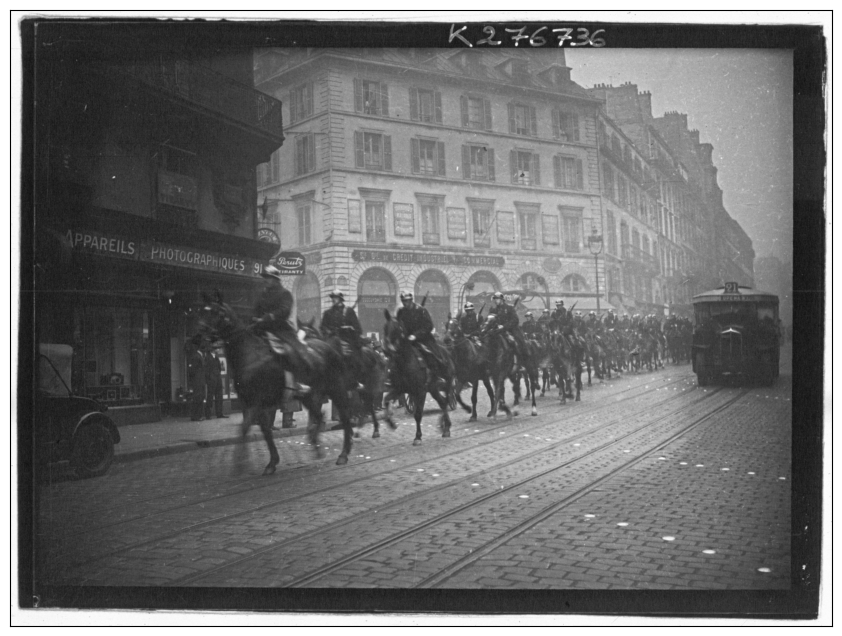

In [12]:
img = skimage.io.imread(doc.images[22])
img_rgb = skimage.color.gray2rgb(img)
plt.figure(figsize=(15, 8))
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([]);

Il est possible de télécharger les images correspondant au document de façon asynchrone. Des limitations subviennent pendant l'utilisation de l'API [IIIF](https://iiif.io/) de la BnF *(hors serveur internet à la BnF)*. Un algorithme de [seau percé](https://fr.wikipedia.org/wiki/Seau_perc%C3%A9) est mise en place afin d'éviter les erreurs dues aux limitations mise en place par l'API.

```{image} fetch_images.jpg
:width: 1000px
:align: center
```

`client_timeout` créer un délai d'expiration d'attente de réponse pour l'application et `get_manifest_timeout` et `get_img_timeout` *overide* ce paramètre chacun pour le type de requête concernant *(par défaut, ils sont égaux à l'application)* `concurrents_img` paramètre le nombre de requêtes autorisé dans une fenêtre égale à `second_img`

```{code-block} python
doc = Document('btv1b106081655')

 >> doc.leaky_bucket 
{'concurrents_img': 50,
 'seconds_img': 60,
 'client_timeout': 60,
 'get_img_timeout': 60,
 'get_manifest_timeout': 60,
 'chunksize': 1024}
```

:::{attention}
:class: dropdown
Ces paramètres n'engendrent pas d'erreur due aux limitations. Il est possible de réécrire ce dictionnaire une fois la classe instancier, mais il est déconseillé d'augmenter le nombre de requêtes autorisé, si le code n'est pas lancé sur le serveur interne de la BnF
:::


**Chaque image est téléchargé selon les paramètres par défaut de la classe.** disponible dans `.params_dft`. Il est possible de réécrire ces paramètres selon les standards mis en place à travers le protocol [IIIF](https://en.wikipedia.org/wiki/International_Image_Interoperability_Framework). La document de l'API est disponible [**ici**](https://iiif.io/api/image/3.0/) elle fournit l'ensemble des *form* disponible et associées à chaque clée du dictionnaire `.params_dft`.

L'utilisateur peut également passer une liste d'images à télécharger à travers la clée `.params_df['image']`. Si une liste est présente l'ensemble des autres paramètres s'appliqueront aux images à moins de passer également une autre liste de même taille où les indices des éléments deviendrons les paramètres à associées.

**Une fois l'image télécharger, le nom de l'image contiendras l'ark et l'ensemble des paramètres associées à celle-ci.** La clée`.params_dft['name']` indique la possibilité d'ajouter un attribut dans le nom du fichier afin de créer une classe d'image *(par défaut, il correspondant à la date de téléchargement)*

```{code-block} python
doc = Document('btv1b106081655')

 >> doc.params_dft
{'name': '202306051337',
 'image': False,
 'region': 'full',
 'size': 'full',
 'rotation': '0',
 'quality': 'native',
 'extension': 'jpg'}
```


Si liste il y a, elles doivent être de même taille

In [13]:
params1 = {
    'name': ['first_img',*['dft']*3,'last_img'] ,
    'image': ['f1','f2','f5','f6','f16'],
    'size' :['full',*['pct:20']*3,'full'],
    'quality':['native',*['gray']*3,'native'],
}

Récupérer l'ensemble des images mais sous deux format différent avec une taille de 50%

In [14]:
params2 = {
    'extension':['jpg','png'],
    'size': 'pct:50'
}

Le dossiers de téléchargement par est `./data/images/`, un nouveau dossier est créer si le dossier présent dans l'argument n'existe pas.
Lors du téléchargement d'image(s) un fichier **.log** est créer qui recense les erreurs.

In [15]:
doc.fetch_image(directory='./data/img/same_lenght',params_img=params1)
doc.fetch_image(directory='./data/img/jpg_png_50percent',params_img=params2)

100%|█████████████████████████████| 54/54 [00:18<00:00,  2.87it/s]


In [16]:
news_params_with_wrong_size = {
    'name': ['first_img','last_img'] ,
    'image': ['f1','f2','f5','f6','f16']
}
#doc.fetch_image(directory='./data/img/from_error',params_img=news_params_with_wrong_size)


```{error}
:class: dropdown  
ValueError: Lenght is not the same between list [2, 5]
```


## Fouille de donnée `research_multiprocessing.py`

In [4]:
import nest_asyncio
nest_asyncio.apply()
'''
De par sa conception, asyncio n'autorise pas l'imbrication de sa boucle d'événements. Cela présente un problème pratique : dans un environnement où la boucle d'événements est déjà en cours d'exécution, il est impossible d'exécuter des tâches et d'attendre le résultat. Essayer de le faire donnera l'erreur "RuntimeError : Cette boucle d'événements est déjà en cours d'exécution".
Le problème apparaît dans divers environnements, tels que les serveurs Web, les applications graphiques et les blocs-notes Jupyter.
Ce module corrige asyncio pour permettre l'utilisation imbriquée de asyncio.run et loop.run_until_complete
Note: seulement nécessaire à l'intérieur d'un jupyterbook
'''
from modules.research_multiprocessing import mapping2csv
from modules.iiif_from_csv import collecting_images
from modules.record import Document
import matplotlib.pyplot  as plt
from itertools import chain
import numpy as np
import pandas as pd
import skimage
import pprint
import random
import time
import json
import os


```{note}
Pour des raisons pratiques un ensemble de collection est disponible au téléchargement via ce lien [Google Drive](https://drive.google.com/drive/folders/1PIurNg4_3YLPwNNN378EEyWRASdg324n?usp=drive_link). Il contient un ensemble de fichiers **.json** appartenant à différentes collections *(set)*
```

Le module `research_multiprocessing` repose sur la recherche chaîne de caractère à l'intérieur des métadonnées. Pour ce faire il suffit de créer un dictionnaire dont la clée indique le `group` associée aux `match` c'est à dire aux chaînes de caractères (sous forme de [regex](https://docs.python.org/fr/3/howto/regex.html)). Cela nous permet de créer **des listes d'autoritée** pour un ensemble d'expression. Si une expression est trouvée, le module retourne `(ark,group,match,from)` le `from` et la correspondance de la clée par rapport aux métadonnée récupérer via l'entrepôt est visible sur Gallica. L'ensemble des correspondances est regroupées sous un fichier **.csv**




```{warning}


:::{image} mapping2csv.jpg
:width: 1000px
:align: center
:::


Lors du lancement de `mapping2csv` le module liste l'ensemble de fichier **.json** présent dans le dossier. L'argument `chunksize` indique le nombre de groupe de fichier que l'ont veut distribuer sur chaque *process*. Le nombre de *process* dépend du nombre *Core* présent sur la machine.    
La création d'un process exige un certain temps, il est donc essentiel d'avoir des fichiers **.json** [ni trop gros, ni trop petit](chunksize_research) en terme de taille. Mais également un `chunksize` qui prend en considération le nombre de **Core**.

Avant la création de chaque batch *(dont leurs taille dépend de `chunksize` et du nombre total de fichier)*. Les fichiers sont mélanger cela permet de rééquilibré la distribution des fichiers par process, car certains fichiers peuvent contenir plus de records *(même si une la taille maximun par fichier est de 20mb, un fichier peu très bien faire une taille de 3mb)*

**Il faut également être prudent lors de la recherche d'expression, par exemple rechercher le mot "il" où "elle" peut générer un fichier CSV avec une taille de plusieurs giga ocet. Mais également se limiter à un dictionnaire résonnable**

```

In [30]:
directory_of_records = './data/json/'
chunksize = 20
n_json = lambda directory: [os.path.join(dirpath,file) for dirpath,_,files in os.walk(directory) 
                                for file in files if fnmatch(file,f'*.json')]
print(f'Le dossier comprend {len(n_json(directory_of_records))} fichiers .json, pour chunksize=20, chaque process traiteras {len(n_json(directory_of_records))//chunksize} fichiers')

Le dossier comprend 453 fichiers .json, pour chunksize=20, chaque process traiteras 22 fichiers


Création d'un dictionnaire, recherche de l'expression Gustave Doré sous le groupe artiste, recherche estampe sous d'une forme de liste d'autorité, recherche des dates correspondant au 20ème sièce, 19ème siècle et 18ème siècle. Recherche un nombre d'expression correspondant à des techniques artistique.
Pour la construction des regex nous utilisons **\\\b** (le double barre oblique est essentiel pour la compilation) qui signifie *boundary* elle sert a délimiter les limites d'un mot **\\\b**_Paris_**\\\b** évite la capture de _Parisiens_

```{note}
:class: dropdown 
La compilation des expréssions régulère se fait en `re.IGNORECASE`, c'est à dire qu'elle ne sont pas sensible aux majuscules et minuscule
```

In [32]:
regex = {
    "artiste":["\\bGustave Doré\\b"],
    "estampe": ["\\bestampe\\b","\\best.\\b" ],
    "date": ["\\b19\d{2}\\b","\\b18\d{2}\\b","\\b17\d{2}\\b"], 
    "techniques":["\\bmine de plomb\\b","\\bfiligrane\\b","\\bdétrempe\\b","\\bsanguine\\b","\\bcraie\bb","\\btempera\\b","\\bcrayon\\b",
                 "\\bplume\\b","\\bpointe de métal\\b","\\bfusain\\b","\\brehauts\\b","\\bgraphite\\b","\\bmétallogallique\\b",
                 "\\bfeutre\\b","\\bstylo\\b","\\bcarbone\\b","\\bpierre noire\\b","\\bpastel\\b",
                 "\\bgouache\\b","\\bmine\\b","\\bgouache\\b","\\bhuile\\b","\\bpinceau\\b","\\bpeinture\\b","\\baquarelle\\b","\\baquarelle\\b",
                "\\bencre\\b","\\bencre\\b","\\bencre de chine\\b","\\blavis\\b","\\bcrachis\\b","\\bbistre\\b"]
}

La barre de progression risque de mettre un certain temps avant de démarrer (le temps de création des process et premiers résultats), sur ma machine (16 core) l'opération total à pris 2:43min

In [33]:
mapping2csv(directory=directory_of_records,chunksize=20,authority=regex,write_at='./data/csv')

Reading files: 100%|█████████| 46/46 [00:23<00:00,  1.95CSVTEMP/s]

8,039,918 rows for 238.45mb for the CSV
7,506,857 records read for a mean of 326,385.09 by process for 16 process by default
8,039,918 matching found with 0 file(s) error(s) during the process


In [17]:
'''
Importation du CSV to low_memory=False, attention ici les 'ARK' ne sont pas unique,
car un 'ARK' peut appartenir à plusieurs group d'expressions
'''
df = pd.read_csv('./data/csv/CSV_16-36-56-06-08-2023.csv', delimiter='|',low_memory=False)
df

,ark,group,match,from
0,bpt6k3370933q,date,1996,date
1,bpt6k3377225x,date,1995,date
2,bpt6k48094479,date,1996,date
3,bpt6k48038754,date,1996,date
4,bpt6k3363957s,date,1996,date
...,...,...,...,...
8039913,bpt6k704210g,date,1882,date
8039914,bpt6k706566z,date,1889,date
8039915,bpt6k713509f,date,1908,date
8039916,bpt6k699905j,date,1874,date


In [58]:
'''
1. Créer une copie du dataframe et filtre le group 'artiste'
2. Suprimme la colonne group
3. Renomme la colonne 'from' en 'artist_from' / 'match' en 'artist'
'''
df_by_artist = df[df['group'].isin(['artiste'])].copy()
df_by_artist.drop('group',axis=1, inplace=True)
df_by_artist.rename(columns={'from': 'artist_from'}, inplace=True)
df_by_artist.rename(columns={'match': 'artist'}, inplace=True)
df_by_artist.T

,299077,606332,606336,606340,609367,609373,609379,609385,609391,609397,...,7774341,7774353,7774379,7774418,7775661,7775744,7775784,7775790,7954648,7959642
ark,btv1b9009264q,btv1b9051042b,btv1b9050998h,btv1b90510000,btv1b103211715,btv1b103211482,btv1b10321221g,btv1b10321188q,btv1b103211895,btv1b103212169,...,btv1b10321436w,btv1b103199797,btv1b10320441q,btv1b103207876,btv1b105357635,btv1b103206369,btv1b10319141c,btv1b10321172m,btv1b9010865p,btv1b105008076
artist,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,...,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré
artist_from,title,title,title,title,relation,relation,relation,relation,relation,relation,...,relation,relation,relation,relation,title,relation,relation,relation,title,title


In [62]:
'''
1. Créer une copie du dataframe et filtre le group 'techniques'
2. Suprimme la colonne group
3. Renomme la colonne 'from' en 'tech_from' / 'match' en 'techniques'
'''
df_by_tech = df[df['group'].isin(['techniques'])].copy()
df_by_tech.drop('group',axis=1, inplace=True)
df_by_tech.rename(columns={'from': 'tech_from'}, inplace=True)
df_by_tech.rename(columns={'match': 'techniques'}, inplace=True)
df_by_tech.T

,3366,3752,16928,16939,16944,16946,16948,16991,17074,17087,...,7959133,7959136,7959420,7959658,7959668,7959690,7959693,7959696,7959701,7982480
ark,bpt6k1525333w,bpt6k1525279j,btv1b84332935,btv1b8433296d,btv1b10031310g,btv1b8432224m,btv1b84061661,btv1b10031423m,btv1b8433294k,btv1b8415210z,...,btv1b7702054r,btv1b7702054r,btv1b7702250s,btv1b10501348r,btv1b10050254t,btv1b64011788,btv1b6401177v,btv1b6401176f,btv1b84126854,bpt6k72243q
techniques,plume,plume,Encre;encre,Encre,encre,encre,Encre,encre,Encre;encre,Encre;encre,...,plume,plume,huile,peinture,lavis;Aquarelle;gouache,aquarelle,aquarelle,aquarelle,plume;lavis,bistre
tech_from,format,format,format,format,format,format,format,format,format,format,...,title,format,description,format,format,format,format,format,format,format


In [69]:
'''
Créer une jointure sur la colonne 'ark'
Le résulat est un df avec toutes les techniques trouver en lien avec l'artiste 'Gustave Doré'
'''
df_jointure = pd.merge(df_by_artist, df_by_tech, on='ark')
df_jointure.T

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
ark,btv1b10320574p,btv1b103200361,btv1b10206303r,btv1b102063046,btv1b103197173,btv1b103197173,btv1b10319720c,btv1b103205771,btv1b10319696k,btv1b10320569h,...,btv1b10322340k,btv1b10319725m,btv1b10320585j,btv1b10319723q,btv1b10319723q,btv1b103197262,btv1b103197497,btv1b10319743j,btv1b10319748s,btv1b103205809
artist,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,...,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré,Gustave Doré
artist_from,relation,relation,title,title,title,relation,relation,relation,relation,relation,...,relation,relation,relation,title,relation,relation,relation,relation,relation,relation
techniques,plume,mine,plume,plume,plume,plume,plume,plume,plume,plume,...,encre,plume,plume,plume,plume,plume,plume,plume,plume,plume
tech_from,format,title,title,title,format,format,format,format,format,format,...,format,format,format,format,format,format,format,format,format,format


In [100]:
'''
1.Filtre quand Gustave Doré est présent dans le le champs des métadonnées correspondant au titre
2.Créer une liste de technique unique en fonction du filtrage précédent
3.Parcours cette liste pour créer un dictionnaire qui rassemble les 'ark' sous les techniques qui sont unique
'''
technique_ark = {}
by_title = df_join[df_join['artist_from'] == 'title']
unique_techniques = by_title['techniques'].unique()
for technique in unique_techniques:
    # Filtrage des ARK pour la technique donnée
    arks = by_title[by_title['techniques'] == technique]['ark'].tolist()
    # Ajouter la technique et la liste d'ARK dans le dictionnaire
    technique_ark[technique] = arks
technique_ark

{'plume': ['btv1b10206303r',
  'btv1b102063046',
  'btv1b103197173',
  'btv1b10319721t',
  'btv1b103196954',
  'btv1b103197245',
  'btv1b10319718j',
  'btv1b10319723q'],
 'Peinture': ['btv1b105397373', 'btv1b105397373']}

In [109]:
"""
Créer un dictionnaire qui pour clée un 'ark' 
et pour valeur un tuple (titre, techniques, nombre d'image pour le document)
"""
ark_title_techniques = {ark: (Document(ark).metadata['title'],technique,len(Document(ark).images)) for technique, ark_list in technique_ark.items() for ark in ark_list}
ark_title_techniques

{'btv1b10206303r': (['Portrait de femme. Dessin à la plume de Gustave Doré (TR)'],
  'plume',
  1),
 'btv1b102063046': (['Alsacienne. Dessin à la plume de Gustave Doré 1872 (TR)'],
  'plume',
  1),
 'btv1b103197173': (['[La Vie en province] : [estampe] ([État avant la lettre]) / [Gustave Doré]'],
  'plume',
  1),
 'btv1b10319721t': (['[Les Collégiens] : [estampe] ([État avant la lettre]) / [Gustave Doré]'],
  'plume',
  1),
 'btv1b103196954': (['[Grotesques] : [estampe] ([État avant la lettre]) / Gustave Doré'],
  'plume',
  1),
 'btv1b103197245': (['[Grotesques : Promenade dans les Champs-Elysées] : [estampe] ([État avant la lettre]) / [Gustave Doré]'],
  'plume',
  1),
 'btv1b10319718j': (['[Internes et externes] : [estampe] ([État avant la lettre]) / [Gustave Doré]'],
  'plume',
  1),
 'btv1b10319723q': (['[Grotesques] : [estampe] ([État avant la lettre]) / Gustave Doré'],
  'plume',
  1),
 'btv1b105397373': (['[Le Géant au dessus des Cévennes] : [photographie] / [Photographie par N

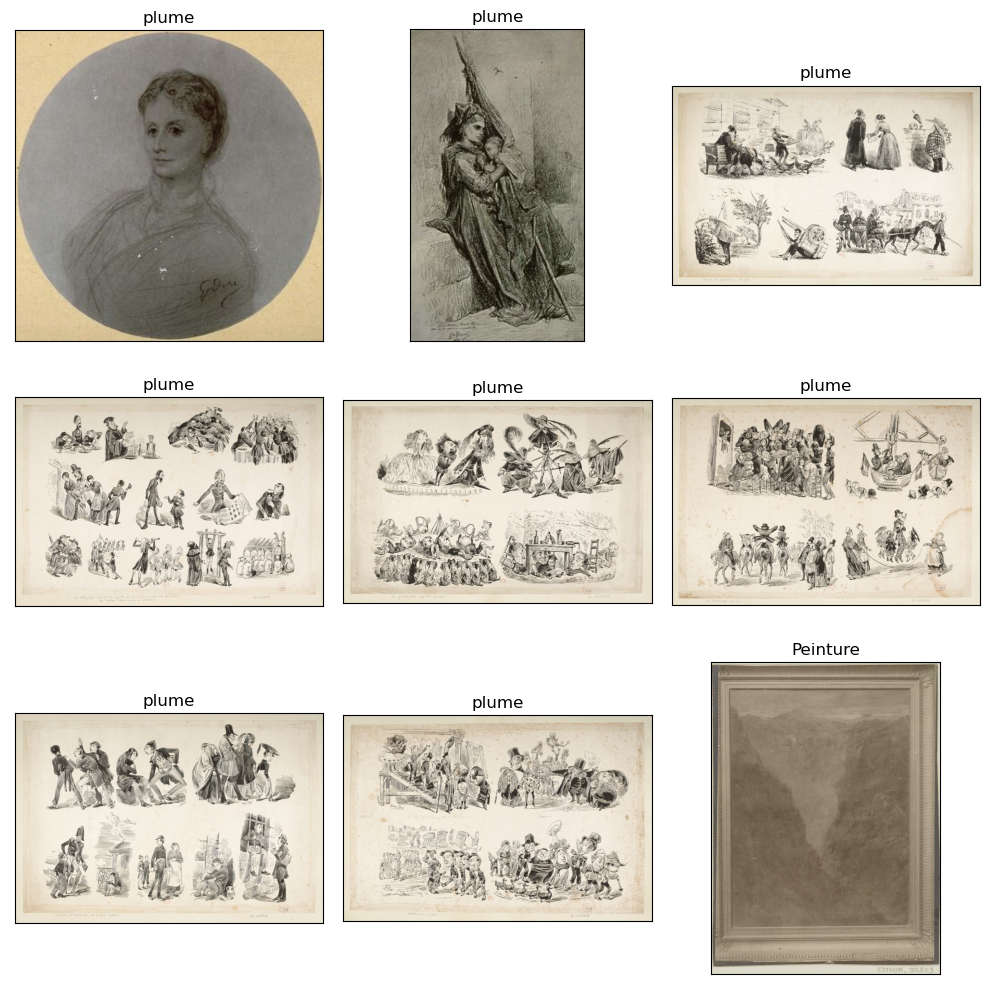

In [129]:
scale = 0.2
num_images = len(ark_title_techniques)  # Nombre total d'images

# Calcul du nombre de lignes et de colonnes pour la grille de sous-graphiques
num_rows = int(np.ceil(np.sqrt(num_images)))
num_cols = int(np.ceil(num_images / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, (ark, tuples) in enumerate(ark_title_techniques.items()):
    # (tips) IIIF n'autorise pas le téléchargement répéter d'image de plus de 50%
    url = Document(ark).images[0].replace('full/full/0/native.jpg','full/pct:30/0/native.jpg')
    img = skimage.io.imread(url)
    img_rgb = skimage.color.gray2rgb(img) if len(img.shape) == 2 else img

    # Ajout de l'image au sous-graphique correspondant
    ax = axes[i // num_cols, i % num_cols]  # Sélection du sous-graphique
    ax.imshow(img_rgb)
    ax.set_title(tuples[1])
    ax.set_xticks([])
    ax.set_yticks([])

# Suppression des sous-graphiques vides (s'il en reste)
if num_images < num_rows * num_cols:
    for i in range(num_images, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

# Ajustement automatique des espacements
plt.tight_layout()
plt.show()

In [9]:
#Création d'un dictionnaire vide avec les 'form' du protocol IIIF
obj = {
    'ark': ark_filtered,
    'image': 'homme_qui_rit',
    'region': 'full',
    'size': 'pct:50',
    'rotation': 0,
    'quality': 'gray',
    'extension': 'jpg'
}

In [10]:
df_iiif = pd.DataFrame(obj)

random_images = lambda ark: '/'.join(random.sample([f'f{i}' for i in range(1,len(Document(ark).images)+1)],len(Document(ark).images) // 2 
                                          if len(Document(ark).images) > 1 else len(Document(ark).images)))

df_iiif['image'] = df_iiif['ark'].apply(random_images)
df_iiif.to_csv('data4notebook/homme_qui_rit_images_random_sample.csv',index=False)
df_iiif    

,ark,image,region,size,rotation,quality,extension
0,btv1b106059979,f23/f20/f21/f6/f14/f11/f1/f3/f7/f10/f16/f18/f5,full,pct:50,0,gray,jpg
1,btv1b9015483s,f1,full,pct:50,0,gray,jpg


```{image} collecting_images.jpg
:width: 1000px
:align: center
```

In [12]:
collecting_images(path='./data4notebook/homme_qui_rit_images_random_sample.csv',directory='./data4notebook/images_from_csv/')

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.04s/it]
